In [ ]:
# Link to data folder:  https://drive.google.com/drive/folders/1SrSh_7AD9DPW2CGjJ_cTVcOPaecWI4sT?usp=sharing
#In this section we are loading the essential libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage.io as io
import os
from PIL import Image
import skimage.transform as trans

from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from skimage.color import rgb2gray
from keras import Input
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.extmath import cartesian
import math
from google.colab import drive

drive.mount("/content/gdrive")

model_save = '/content/gdrive/My Drive/Colab Notebooks/model/'
prediction_save = '/content/gdrive/My Drive/Colab Notebooks/prediction/'
def maybe_mkdir(path):

  if os.path.exists(path): # checking to see if a folder with name already exists at that location
    print("Directory exists moving on ...")
  else:
    model_save = os.mkdir(path) # Creating a folder to save our model in
    print('Created directory')


maybe_mkdir(prediction_save)
maybe_mkdir(model_save)


Mounted at /content/gdrive
Directory exists moving on ...
Directory exists moving on ...


**Loading the data & plotting the images**

(-0.5, 511.5, 511.5, -0.5)

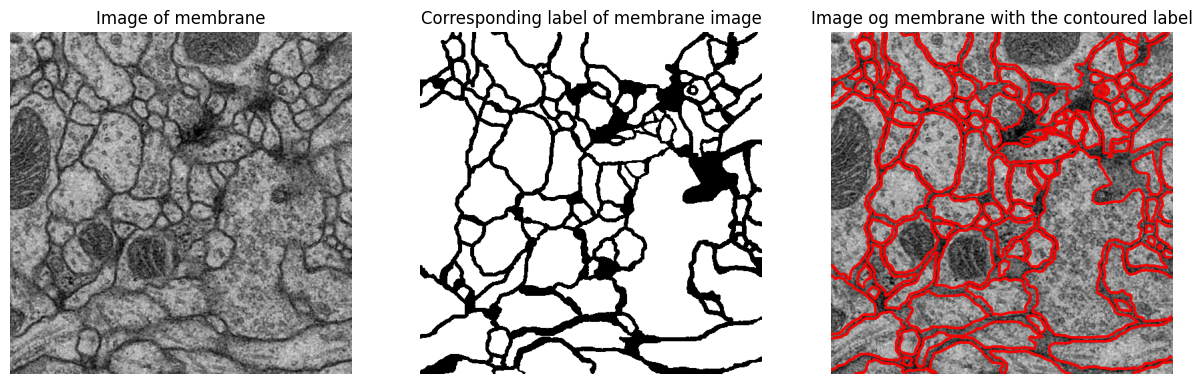

In [ ]:
#This section loads the directories. This is location of the input data.
TRAIN_INPUT_DIR = '/content/gdrive/My Drive/Colab Notebooks/Membrane/train/' #This is the path for training data
VAL_INPUT_DIR = '/content/gdrive/My Drive/Colab Notebooks/Membrane/val/' #This is the path for validation data

im = Image.open(TRAIN_INPUT_DIR + 'image_folder/12.png')
lbl = Image.open(TRAIN_INPUT_DIR + 'gt_folder/12.png')

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,15))
ax1.imshow(im,cmap='gray')
ax2.imshow(lbl,cmap='gray')
ax3.imshow(im,cmap='gray')
ax3.contour(lbl,alpha=0.35,colors = 'red')
ax1.title.set_text('Image of membrane')
ax2.title.set_text('Corresponding label of membrane image')
ax3.title.set_text('Image og membrane with the contoured label')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

**Checking the shape of the images**

In [ ]:

im = Image.open(TRAIN_INPUT_DIR + 'image_folder/12.png')
lbl = Image.open(TRAIN_INPUT_DIR + 'gt_folder/12.png')

imarray = np.array(im)
lblarray = np.array(lbl)

print(imarray.shape)
print(lblarray.shape)

if(len(imarray.shape)<3):
      print('gray')
elif len(imarray.shape)==3:
      print('Color(RGB)')
else:
      print('others')

(512, 512)
(512, 512)
gray


**Normalization of the images**

You have not learned about this. However, normalization is standard procedure in deep learning primary done for greater performance of the neural network. It scales the values in the data to a common scale without distorting the difference in the ranges of values or losing information.

In [ ]:
def adjust_data(img,gt,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        gt = gt[:,:,:,0] if(len(gt.shape) == 4) else gt[:,:,0]
        new_gt = np.zeros(gt.shape + (num_class,))
        for i in range(num_class):
            new_gt[gt == i,i] = 1
        new_gt = np.reshape(new_gt,(new_gt.shape[0],new_gt.shape[1]*new_gt.shape[2],new_gt.shape[3])) if flag_multi_class else np.reshape(new_gt,(new_gt.shape[0]*new_gt.shape[1],new_gt.shape[2]))
        gt = new_gt
    elif(np.max(img) > 1):
        img = img / 255
        gt = gt /255
        gt[gt >= 0.5] = 1
        gt[gt < 0.5] = 0
    return (img,gt)

**Define the train generator**

In [ ]:
def trainGenerator(batch_size, train_path,image_folder,gt_folder,aug_dict,image_color_mode = "grayscale", gt_color_mode = 'grayscale', image_save_prefix ="image",gt_save_prefix = "gt", flag_multi_class = False, num_class = 2, save_to_dir = None, target_size = (512,512), seed = 1):

    image_datagen = ImageDataGenerator(**aug_dict)
    gt_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_directory(train_path,classes=[image_folder],class_mode=None,color_mode = image_color_mode,target_size=target_size,batch_size=batch_size,save_to_dir=save_to_dir,save_prefix = image_save_prefix,seed=seed)
    gt_generator = gt_datagen.flow_from_directory(train_path,classes=[gt_folder],class_mode=None,color_mode = gt_color_mode,target_size=target_size,batch_size=batch_size,save_to_dir=save_to_dir,save_prefix = gt_save_prefix,seed=seed)

    train_generator = zip(image_generator,gt_generator)

    for (img,gt) in train_generator:
        img, gt = adjust_data(img,gt,flag_multi_class,num_class)
        yield (img,gt)


**Define the metric & cost function**

In [ ]:
smooth = 1.0

def dice_coef(y_true,y_pred):
    y_truef = K.flatten(y_true)
    y_predf = K.flatten(y_pred)
    And = K.sum(y_truef * y_predf)
    return ((2*And + smooth)/(K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

**Consctruct the UNet**

This section will be done as *code along*

In [ ]:
def unet(input_size =(512,512,1)):
    inputs = Input(input_size)

    conv1 = Conv2D(64,(3,3),padding ='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64,(3,3),padding = 'same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size = (2,2))(bn1)

    conv2 = Conv2D(128,(3,3),padding = 'same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128,(3,3),padding = 'same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size =(2,2))(bn2)

    conv3 = Conv2D(256,(3,3),padding = 'same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256,(3,3),padding = 'same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size =(2,2))(bn3)

    conv4 = Conv2D(512,(3,3),padding = 'same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512,(3,3),padding = 'same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size =(2,2))(bn4)

    conv5 = Conv2D(1024,(3,3),padding = 'same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024,(3,3),padding = 'same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

**Define the hyperparameters, optimizer, cost function, metric & data augmentation**

In [ ]:
epochs = 80 # Change based upon the used data
batch = 2 # Change based upon the used data
learning_rate = 1e-4 # Highly dependent on the data (e.g. segmentation of brain tumour(s))
LenghtTrainData = 20 # Change accordingly based on your data size
LengthValData = 10 # Change accordingly based on your data size

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, amsgrad=False)
cost_function = dice_coef_loss
metric = dice_coef

data_gen_args = dict(rotation_range=0.2, width_shift_range=0.05, height_shift_range=0.05, shear_range=0.05, zoom_range=0.05, horizontal_flip=True, fill_mode='nearest')



Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.
Epoch 1/80
10/10 [==============================] - ETA: 0s - loss: 0.3733 - dice_coef: 0.6267Found 10 images belonging to 1 classes.
Found 10 images belonging to 1 classes.

Epoch 1: val_loss improved from inf to 0.36658, saving model to /content/gdrive/My Drive/Colab Notebooks/model/unet_seg.hdf5
10/10 [==============================] - 88s 7s/step - loss: 0.3733 - dice_coef: 0.6267 - val_loss: 0.3666 - val_dice_coef: 0.6334
Epoch 2/80
10/10 [==============================] - ETA: 0s - loss: 0.2470 - dice_coef: 0.7530
Epoch 2: val_loss improved from 0.36658 to 0.34177, saving model to /content/gdrive/My Drive/Colab Notebooks/model/unet_seg.hdf5
10/10 [==============================] - 7s 678ms/step - loss: 0.2470 - dice_coef: 0.7530 - val_loss: 0.3418 - val_dice_coef: 0.6582
Epoch 3/80
10/10 [==============================] - ETA: 0s - loss: 0.1874 - dice_coef: 0.8126
Epoch 3: val_loss improved from 0.341

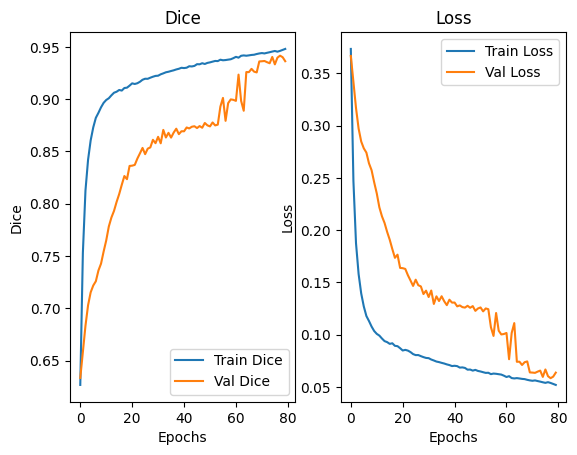

In [ ]:
train_genr = trainGenerator(batch, TRAIN_INPUT_DIR, 'image_folder', 'gt_folder', data_gen_args, target_size=(512, 512))
val_gener = trainGenerator(batch, VAL_INPUT_DIR, 'image_folder', 'gt_folder', dict(), target_size=(512, 512))

model = unet(input_size=(512, 512, 1))

model.compile(optimizer=optimizer, loss=cost_function, metrics=[metric])

callbacks = [ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/model/unet_seg.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_genr, steps_per_epoch= LenghtTrainData/batch, epochs=epochs, callbacks=callbacks, validation_data=val_gener, validation_steps= LengthValData / batch)

a = history.history

list_traindice = a['dice_coef']
list_valdice = a['val_dice_coef']

list_trainloss = a['loss']
list_valoss = a['val_loss']

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(list_traindice,label = 'Train Dice')
ax1.plot(list_valdice,label = 'Val Dice')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Dice')
ax1.title.set_text('Dice')
ax1.legend()

ax2.plot(list_trainloss, label = "Train Loss")
ax2.plot(list_valoss,label = "Val Loss")
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.title.set_text('Loss')
ax2.legend()


1/1 [==============================] - 12s 12s/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/1_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 25ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/2_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 21ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/3_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 33ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/4_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 164ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/5_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 38ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/6_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 21ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/7_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 24ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/8_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 21ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/9_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 21ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/10_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 21ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/11_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 21ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/12_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 22ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/13_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 23ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/14_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 24ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/15_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 22ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/16_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 21ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/17_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 22ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/18_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 24ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/19_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 24ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/20_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 20ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/21_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 30ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/22_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 34ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/23_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 38ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/24_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 22ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/25_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 21ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/26_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 25ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/27_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


1/1 [==============================] - 0s 22ms/step


<ipython-input-2-34c05d8cee63>:13: UserWarning: /content/gdrive/My Drive/Colab Notebooks/prediction/28_predict.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


(-0.5, 511.5, 511.5, -0.5)

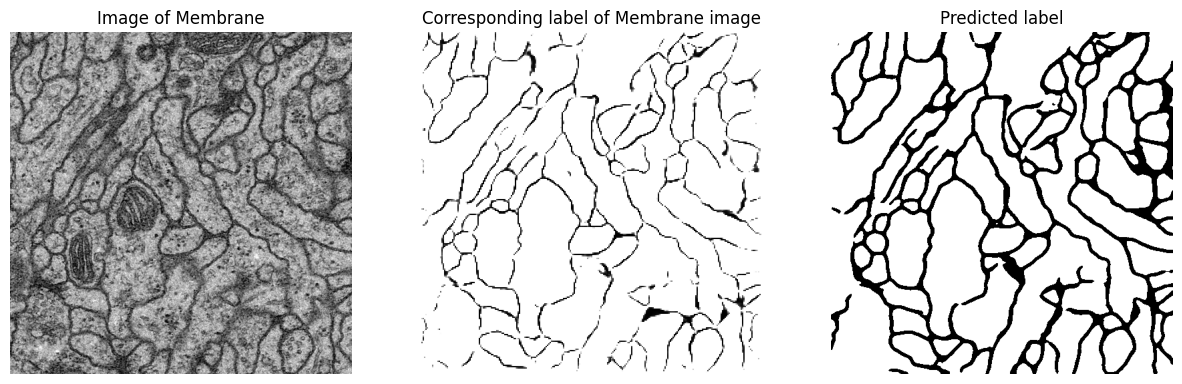

In [ ]:

model = load_model('/content/gdrive/My Drive/Colab Notebooks/model/unet_seg.hdf5', custom_objects={'dice_coef_loss': "dice_coef_loss", 'dice_coef': "dice_coef"})

test_image_path = '/content/gdrive/My Drive/Colab Notebooks/Membrane/test/image_folder/'
test_gt_path = '/content/gdrive/My Drive/Colab Notebooks/Membrane/test/gt_folder/'
save_path = '/content/gdrive/My Drive/Colab Notebooks/prediction/'

for i in range(1,29):
    img = io.imread(os.path.join(test_image_path,"%d.png"%i))
    img = img / 255
    img = np.reshape(img,(1,)+img.shape)
    pred = model.predict(img, verbose = 1)
    prediction = np.squeeze(pred) > .5
    io.imsave(os.path.join(save_path,"%d_predict.png"%i),prediction)


im_test = Image.open(test_image_path + '/12.png')
lbl_test = Image.open(test_gt_path + '/12_predict.png')
pred_test = Image.open(save_path + '/12_predict.png')

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,15))
ax1.imshow(im_test,cmap='gray')
ax2.imshow(lbl_test,cmap='gray')
ax3.imshow(pred_test,cmap='gray')
ax1.title.set_text('Image of Membrane')
ax2.title.set_text('Corresponding label of Membrane image')
ax3.title.set_text('Predicted label')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
